In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def generate_regression_data(n_samples=200, noise_std=0.3):
    X = torch.linspace(-5, 5, n_samples).unsqueeze(1)
    y = torch.sin(X) + 0.1 * X**2 + torch.randn(n_samples, 1) * noise_std
    return X, y

In [ ]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

In [ ]:
class Nesterov(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, weight_decay=0, dampening=0):
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay)
        super(Nesterov, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = torch.zeros_like(p)
                else:
                    buf = param_state['momentum_buffer']

                buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                d_p = d_p.add(buf, alpha=momentum)
                p.add_(d_p, alpha=-group['lr'])
        return loss

In [ ]:
class Adam(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super(Adam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * (bias_correction2 ** 0.5) / bias_correction1

                p.addcdiv_(exp_avg, denom, value=-step_size)
        return loss

In [ ]:
class RMSProp(optim.Optimizer):
    def __init__(self, params, lr=1e-2, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0):
      defaults = dict(lr=lr, alpha=alpha, eps=eps, weight_decay=weight_decay, momentum=momentum)
      super(RMSProp, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
          for p in group['params']:
            if p.grad is None:
              continue
            grad = p.grad
            if group['weight_decay'] != 0:
              grad = grad.add(p, alpha=group['weight_decay'])

            state = self.state[p]
            if len(state) == 0:
                state['step'] = 0
                state['square_avg'] = torch.zeros_like(p)
                state['momentum_buffer'] = torch.zeros_like(p) if group['momentum'] != 0 else None

            square_avg = state['square_avg']
            alpha = group['alpha']
            square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)


            if group['momentum'] != 0:
                momentum_buffer = state['momentum_buffer']
                momentum = group['momentum']
                momentum_buffer.mul_(momentum).addcdiv_(grad, square_avg.sqrt().add_(group['eps']), value=1)
                p.add_(momentum_buffer, alpha=-group['lr'])
            else:
                p.addcdiv_(grad, square_avg.sqrt().add_(group['eps']), value=-group['lr'])
        return loss

In [ ]:
class StepLR:
    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1):
      self.optimizer = optimizer
      self.step_size = step_size
      self.gamma = gamma
      self.last_epoch = last_epoch
      self.last_lr = [group['lr'] for group in optimizer.param_groups]

    def step(self):
      self.last_epoch += 1
      if (self.last_epoch % self.step_size) == 0:
        for group, lr in zip(self.optimizer.param_groups, self.last_lr):
          group['lr'] = lr * self.gamma
        self.last_lr = [group['lr'] for group in self.optimizer.param_groups]


class ExponentialLR:
    def __init__(self, optimizer, gamma, last_epoch=-1):
        self.optimizer = optimizer
        self.gamma = gamma
        self.last_epoch = last_epoch
        self.last_lr = [group['lr'] for group in optimizer.param_groups]

    def step(self):
      self.last_epoch += 1
      for group, lr in zip(self.optimizer.param_groups, self.last_lr):
        group['lr'] = lr * self.gamma
      self.last_lr = [group['lr'] for group in self.optimizer.param_groups]

In [ ]:
def train_model(model, X, y, optimizer, scheduler, num_epochs=100):
  criterion = nn.MSELoss()
  lr_history = []

  for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()

    lr_history.append(optimizer.param_groups[0]['lr'])

    if scheduler:
      scheduler.step()

    if (epoch + 1) % 10 == 0:
        print(f'Эпоха [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

  return lr_history


Эпоха [10/100], Loss: 2.2848
Эпоха [20/100], Loss: 1.9175
Эпоха [30/100], Loss: 1.6649
Эпоха [40/100], Loss: 1.4714
Эпоха [50/100], Loss: 1.3527
Эпоха [60/100], Loss: 1.2780
Эпоха [70/100], Loss: 1.2322
Эпоха [80/100], Loss: 1.2047
Эпоха [90/100], Loss: 1.1881
Эпоха [100/100], Loss: 1.1782


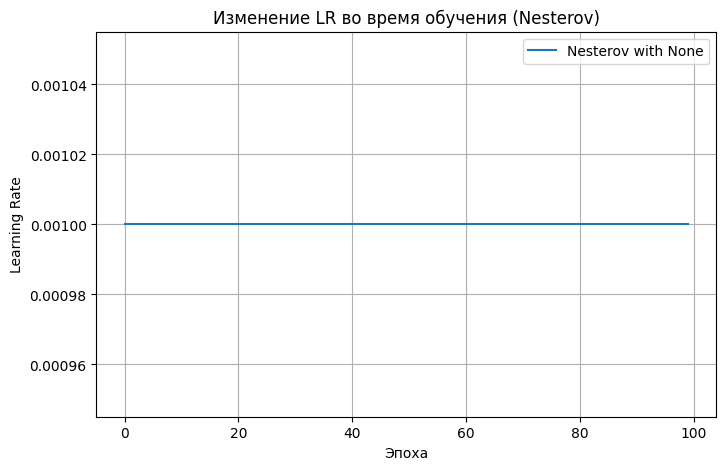

Эпоха [10/100], Loss: 4.2352
Эпоха [20/100], Loss: 3.7971
Эпоха [30/100], Loss: 3.3946
Эпоха [40/100], Loss: 3.2973
Эпоха [50/100], Loss: 3.2659
Эпоха [60/100], Loss: 3.2356
Эпоха [70/100], Loss: 3.2274
Эпоха [80/100], Loss: 3.2245
Эпоха [90/100], Loss: 3.2216
Эпоха [100/100], Loss: 3.2208


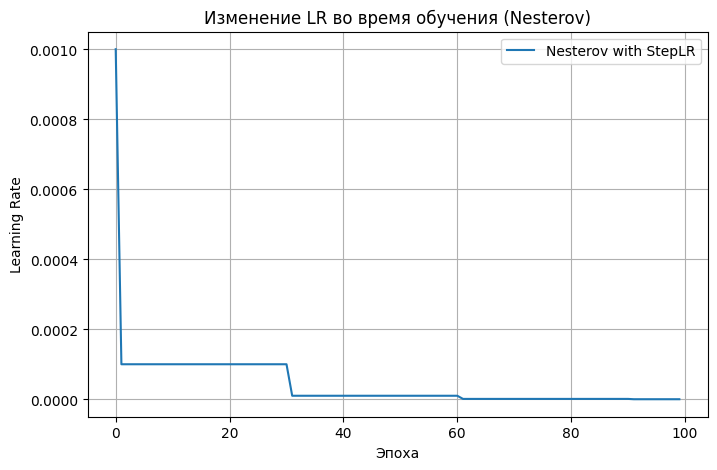

Эпоха [10/100], Loss: 2.2969
Эпоха [20/100], Loss: 1.6514
Эпоха [30/100], Loss: 1.5102
Эпоха [40/100], Loss: 1.4730
Эпоха [50/100], Loss: 1.4617
Эпоха [60/100], Loss: 1.4581
Эпоха [70/100], Loss: 1.4568
Эпоха [80/100], Loss: 1.4564
Эпоха [90/100], Loss: 1.4562
Эпоха [100/100], Loss: 1.4562


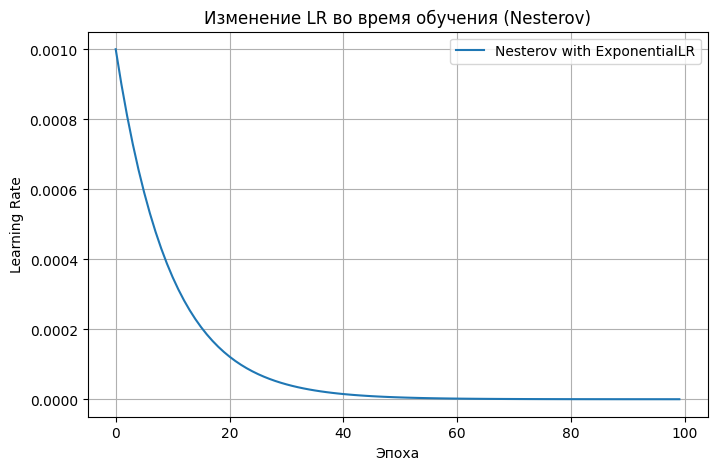

Эпоха [10/100], Loss: 3.4851
Эпоха [20/100], Loss: 3.4012
Эпоха [30/100], Loss: 3.3197
Эпоха [40/100], Loss: 3.2408
Эпоха [50/100], Loss: 3.1644
Эпоха [60/100], Loss: 3.0906
Эпоха [70/100], Loss: 3.0194
Эпоха [80/100], Loss: 2.9507
Эпоха [90/100], Loss: 2.8844
Эпоха [100/100], Loss: 2.8205


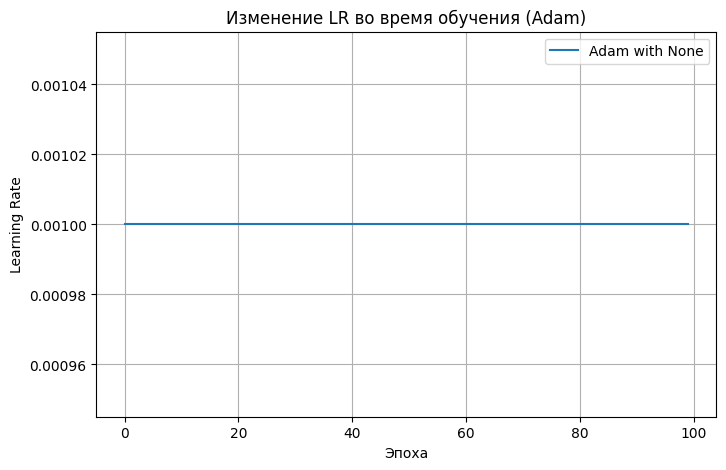

Эпоха [10/100], Loss: 8.4596
Эпоха [20/100], Loss: 8.4436
Эпоха [30/100], Loss: 8.4277
Эпоха [40/100], Loss: 8.4232
Эпоха [50/100], Loss: 8.4216
Эпоха [60/100], Loss: 8.4200
Эпоха [70/100], Loss: 8.4195
Эпоха [80/100], Loss: 8.4194
Эпоха [90/100], Loss: 8.4192
Эпоха [100/100], Loss: 8.4192


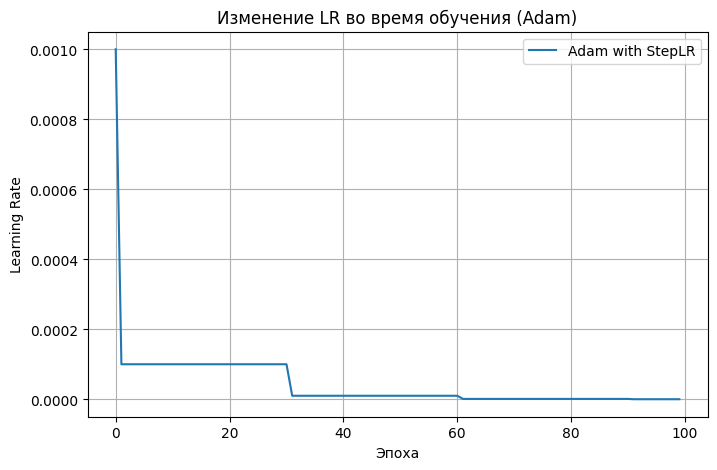

Эпоха [10/100], Loss: 6.9985
Эпоха [20/100], Loss: 6.9615
Эпоха [30/100], Loss: 6.9487
Эпоха [40/100], Loss: 6.9442
Эпоха [50/100], Loss: 6.9426
Эпоха [60/100], Loss: 6.9421
Эпоха [70/100], Loss: 6.9419
Эпоха [80/100], Loss: 6.9418
Эпоха [90/100], Loss: 6.9418
Эпоха [100/100], Loss: 6.9418


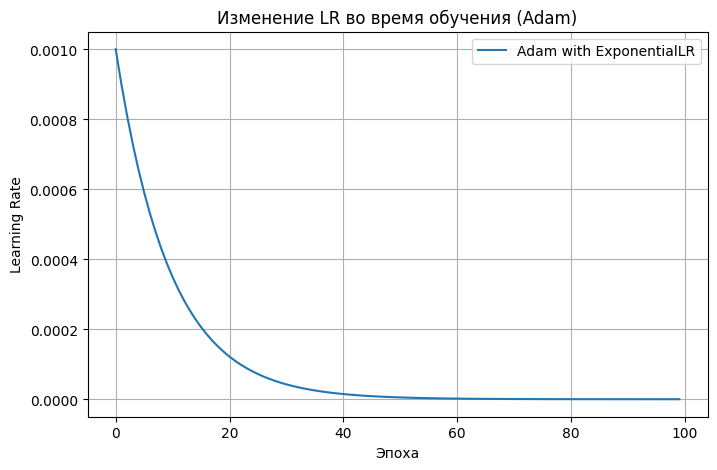

Эпоха [10/100], Loss: 7.2808
Эпоха [20/100], Loss: 6.9282
Эпоха [30/100], Loss: 6.6653
Эпоха [40/100], Loss: 6.4473
Эпоха [50/100], Loss: 6.2575
Эпоха [60/100], Loss: 6.0874
Эпоха [70/100], Loss: 5.9320
Эпоха [80/100], Loss: 5.7882
Эпоха [90/100], Loss: 5.6539
Эпоха [100/100], Loss: 5.5274


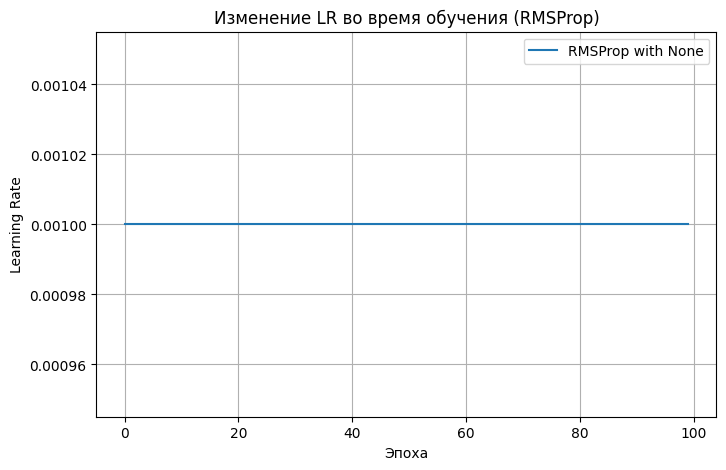

Эпоха [10/100], Loss: 5.7114
Эпоха [20/100], Loss: 5.6770
Эпоха [30/100], Loss: 5.6503
Эпоха [40/100], Loss: 5.6436
Эпоха [50/100], Loss: 5.6416
Эпоха [60/100], Loss: 5.6397
Эпоха [70/100], Loss: 5.6391
Эпоха [80/100], Loss: 5.6390
Эпоха [90/100], Loss: 5.6388
Эпоха [100/100], Loss: 5.6388


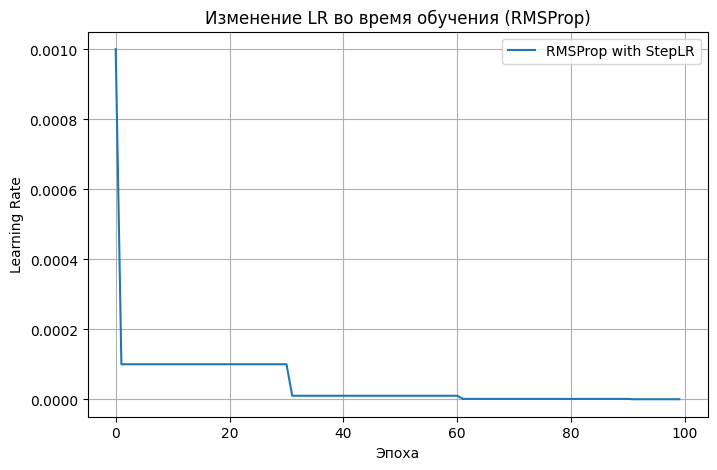

Эпоха [10/100], Loss: 3.3467
Эпоха [20/100], Loss: 3.2871
Эпоха [30/100], Loss: 3.2712
Эпоха [40/100], Loss: 3.2664
Эпоха [50/100], Loss: 3.2649
Эпоха [60/100], Loss: 3.2644
Эпоха [70/100], Loss: 3.2643
Эпоха [80/100], Loss: 3.2642
Эпоха [90/100], Loss: 3.2642
Эпоха [100/100], Loss: 3.2642


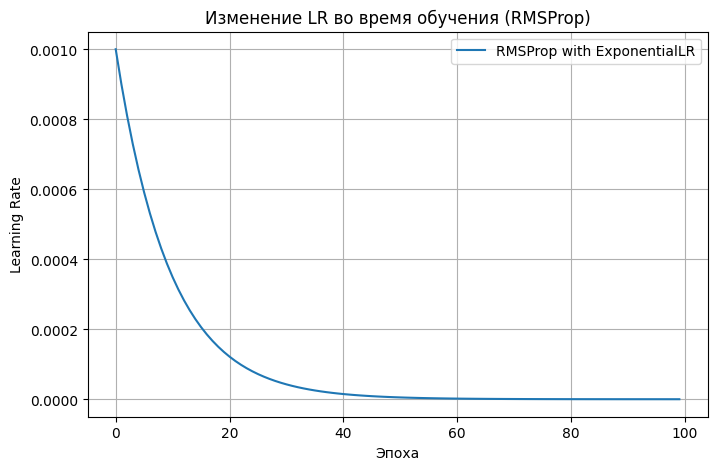

In [ ]:
def plot_lr_schedule(lr_history, optimizer_name, scheduler_name):
  plt.figure(figsize=(8, 5))
  plt.plot(lr_history, label=f'{optimizer_name} with {scheduler_name if scheduler_name else "None"}')
  plt.title(f'Изменение LR во время обучения ({optimizer_name})')
  plt.xlabel('Эпоха')
  plt.ylabel('Learning Rate')
  plt.grid(True)
  plt.legend()
  plt.show()


if __name__ == '__main__':
  torch.manual_seed(42)
  X, y = generate_regression_data()

  optimizers = ['Nesterov', 'Adam', 'RMSProp']
  schedulers = [None, 'StepLR', 'ExponentialLR']
  learning_rate = 0.001
  num_epochs = 100

  for optimizer_name in optimizers:
      for scheduler_name in schedulers:

          model = RegressionModel()

          if optimizer_name == 'Nesterov':
              optimizer = Nesterov(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
          elif optimizer_name == 'Adam':
              optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-5)
          elif optimizer_name == 'RMSProp':
              optimizer = RMSProp(model.parameters(), lr=learning_rate, alpha=0.99, weight_decay=1e-5)

          if scheduler_name == 'StepLR':
              scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
          elif scheduler_name == 'ExponentialLR':
              scheduler = ExponentialLR(optimizer, gamma=0.9)
          else:
              scheduler = None

          lr_history = train_model(model, X, y, optimizer, scheduler, num_epochs=num_epochs)
          plot_lr_schedule(lr_history, optimizer_name, scheduler_name)